- To Do
1. Order Date 변수랑 Previous Order Date 변수를 어떻게 머신러닝에 X로 입력시킬지 찾아보기

- 선행 프로젝트
---
1. stockx 동일한 데이터 이용한 프로젝트(Price Regression): https://ichi.pro/ko/meosin-leoning-eulo-stockx-undonghwa-gagyeog-yecheug-260157814980288
2. stockx 동일한 데이터 이용한 프로젝트(Price Regression): https://www.kaggle.com/logannorman/stockx-sneaker-price-regression
3. https://www.kaggle.com/hudsonstuck/stockx-data-contest
4. 머신 러닝 기법을 활용한 한정판 운동화 리셀 여부 예측 및 수익성 평가 (서울대학교 대학원 석사 논문): https://s-space.snu.ac.kr/handle/10371/166432 
=> SVM, Random Forest, Ensemble 등의 머신러닝 기법을 이용해서 특정 한정판 신발의 "리셀 여부"(Binary Classification) 예측함
---
- 선행 프로젝트 1,2,3에서 Price Regression을 하는 과정에서 Train/Test를 Split할 때 시계열성을 무시하고 Shuffle = True(사이킷런 train_test_split 함수에서 shuffle = True가 Default임)로 데이터를 나눴는데 이렇게 되면, 미래 정보가 훈련에 반영되는 Data Leakage 문제가 발생함. (1은 확실하지는 않음)
- 그렇다면 나는 이거에 포인트를 두고, 시계열성을 반영해서 Train/Test를 시간 순서에 따라 나눠서 모델을 수립해보자!
- 선행 프로젝트 2에서는 데이터셋 전체를 한 번에 Input으로 넣어서 Linear Regression에 돌림. => 실제로 StockX, Kream, SoldOut 등 신발 거래 어플에서는 Sneaker Name 별로 원하는 사이즈를 선택해서 거래가 이뤄짐. => Sneaker Name 별로 데이터프레임을 분리해서 Date Avg Sale Price를 Regression 하는 모델 수립하기 (해당 방법의 단점: 전체 데이터를 Sneaker Name에 따라 여러 개로 분리함에 따라 각 데이터프레임의 데이터 수가 최대 500여개로 데이터가 매우 적음,,,)
- 선행 프로젝트에서 얻은 아이디어: Categorical 변수들을 One-Hot Encoding을 해서 사용했음

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 데이터 불러오기

In [ ]:
df_og = pd.read_csv('/content/drive/MyDrive/PersonalProject/sneakers/stockx_final.csv', encoding = 'utf-8-sig')
df_og.drop(columns = ['Unnamed: 0'], inplace = True)

In [ ]:
df = df_og.copy()
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release,Previous Order Date
0,2017-11-16,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,600,220,2017-11-25,310,Michigan,633,-9,2019-02-13
1,2017-11-17,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,605,220,2017-11-25,290,Tennessee,618,-8,2017-11-16
2,2017-11-18,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,679,220,2017-11-25,250,New Jersey,633,-7,2017-11-17
3,2017-11-19,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,600,220,2017-11-25,270,Washington,594,-6,2017-11-18
4,2017-11-20,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,598,220,2017-11-25,290,California,566,-5,2017-11-19


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116 entries, 0 to 5115
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Order Date           5116 non-null   object
 1   Brand                5116 non-null   object
 2   Sneaker Name         5116 non-null   object
 3   Sale Price           5116 non-null   int64 
 4   Retail Price         5116 non-null   int64 
 5   Release Date         5116 non-null   object
 6   Shoe Size            5116 non-null   int64 
 7   Buyer Region         5116 non-null   object
 8   Date Avg Sale Price  5116 non-null   int64 
 9   Days After Release   5116 non-null   int64 
 10  Previous Order Date  5116 non-null   object
dtypes: int64(5), object(6)
memory usage: 439.8+ KB


- **주의!! 모델에 넣기 전에 string(object) 형태의 변수(Column)들은 원핫 인코딩 등을 통해 숫자 형태로 값을 바꿔줘야 한다!!!**
- 아무 생각없이 문자열 그대로 둔 상태로 Keras 모델 수립해보니까 인풋 데이터 형태가 잘못됐다고 모델이 돌아가지가 않더라

In [ ]:
# 시계열 분석을 위해 Order Date 기준으로 정렬
df.sort_values(by = 'Order Date', inplace = True) 

- 만약 Sneaker Name을 독립 변수로 사용하게 되면 발생하는 문제점: Train/Valid/Test Set을 Order Date를 기준으로 순서대로 나누게 되는데, 그렇게 되면 Release Date가 비교적 최근인 Sneaker Name들은 Train에 사용되지 못해서 모델이 Date Avg Sale Price를 올바르게 예측하지 못하게 된다.

In [ ]:
# Order Date 별로 몇 개의 Sneaker Name이 존재하는지 확인하기
df.groupby(df['Order Date']).count()['Sneaker Name'].describe()

count    531.000000
mean       9.634652
std        4.164795
min        2.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       18.000000
Name: Sneaker Name, dtype: float64

In [ ]:
df['Sneaker Name'].value_counts()

Adidas Yeezy Boost 350 V2 Cream White                531
Adidas Yeezy Boost 350 V2 Zebra                      531
Adidas Yeezy Boost 350 V2 Beluga 2pt0                455
Adidas Yeezy Boost 350 V2 Blue Tint                  432
Air Jordan 1 Retro High Off White University Blue    270
Nike Air VaporMax Off White 2018                     270
adidas Yeezy Boost 350 V2 Butter                     240
Nike Air Presto Off White White 2018                 215
Nike Air Presto Off White Black 2018                 206
Nike Air VaporMax Off White Black                    192
Adidas Yeezy Boost 350 V2 Semi Frozen Yellow         173
Nike Blazer Mid Off White All Hallows Eve            148
Nike Blazer Mid Off White Grim Reaper                148
Nike Air Presto Off White                            128
Adidas Yeezy Boost 350 V2 Core Black Red 2017         98
Adidas Yeezy Boost 350 V2 Sesame                      95
Air Jordan 1 Retro High Off White Chicago             90
Nike Zoom Fly Mercurial Off Whi

# 데이터 전처리
- Sneaker Name 별로 데이터 프레임을 분리해서 각 Sneaker Name 별로 예측 모델 수립할 예정

In [ ]:
# 전체 데이터를 Sneaker Name별로 데이터 프레임 분리해서 리스트에 넣기
names = df['Sneaker Name'].unique().tolist()

df_list = []
for name in names:
  temp_df = df[df['Sneaker Name'] == name]
  temp_df.reset_index(drop = True, inplace = True)
  df_list.append(temp_df) # Sneaker Name별로 데이터프레임 불러오는 거는 df_list[0], df_list[1]과 같이 불러올 수 있음

len(df_list)

30

In [ ]:
# names[0]에 해당하는 Sneaker Name의 Date Avg Sale Price Regression 모델 수립하기
# 이 블록부터 코드는 추후에 사용자 정의 함수 형태나 클래스 형태로 만들어서 사용하기!!!

# Converting dates into numericals
import datetime as dt
df_list[0]['Order Date'] = pd.to_datetime(df_list[0]['Order Date'])
df_list[0]['Order Date']=df_list[0]['Order Date'].map(dt.datetime.toordinal)

df_list[0]['Previous Order Date'] = pd.to_datetime(df_list[0]['Previous Order Date'])
df_list[0]['Previous Order Date']=df_list[0]['Previous Order Date'].map(dt.datetime.toordinal)

# Sneaker Name 무엇인지 저장 
sneaker_name = df_list[0]['Sneaker Name'].unique()[0]

# Retail Price 저장 
retail_price = df_list[0]['Retail Price'].unique()[0]

# Brand 저장 
brand = df_list[0]['Brand'].unique()[0]

# Release Date 저장
release_date = df_list[0]['Release Date'].unique()[0]

# Sneaker Name, Retail Price, Brand 변수 데이터프레임에서 지우기 (지우는 이유: 특정 Sneaker Name의 Date Avg Sale Price를 예측하는데, Sneaker Name과 Retail Price는 고정된 값이라서 모델 성능 향상에 영향 X)
df_list[0].drop(columns = ['Sneaker Name', 'Retail Price', 'Brand', 'Release Date'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
df_list[0].dtypes

Order Date              int64
Sale Price              int64
Shoe Size               int64
Buyer Region           object
Date Avg Sale Price     int64
Days After Release      int64
Previous Order Date     int64
dtype: object

# Regression Modeling

## Split X/Y * Train/Valid/Test Set

In [ ]:
# x,y 나누기
x = df_list[0].drop(columns= ['Date Avg Sale Price'], axis = 1)
y = df_list[0]['Date Avg Sale Price']
print(x.shape, y.shape)

(531, 6) (531,)


In [ ]:
len(x)

531

In [ ]:
# 시계열 데이터는 과거 데이터부터 순서대로 Train/Valid/Test Set 나눠줘야 한다
# Train/Valid/Test .6 : .2 : .2로 나누기

train_cnt = int(len(x) * .6)
valid_cnt = int(len(x) * .8)
test_cnt = len(x)

train_x = x.iloc[:train_cnt,:]
valid_x = x.iloc[train_cnt:valid_cnt,:]
valid_x.reset_index(drop = True, inplace = True)
test_x = x.iloc[valid_cnt:,:]
test_x.reset_index(drop = True, inplace = True)

train_y = y[:train_cnt]
valid_y = y[train_cnt:valid_cnt]
test_y = y[valid_cnt:]

print((train_x.shape, train_y.shape))
print((valid_x.shape, valid_y.shape))
print((test_x.shape, test_y.shape))

((318, 6), (318,))
((106, 6), (106,))
((107, 6), (107,))


## Several Regression Model Try

### Artificial Neural Networks

In [ ]:
# 문자열인 "Buyer Region" 변수를 One-hot Encoder를 통해 One-Hot Vector로 변환
# One-Hot Encoder 사용 예시 참고: https://psystat.tistory.com/136
# 주의! Train/Test를 나눈 후에 Encoder를 통해 Categorical 변수를 Vector화시킨다!
# LabelEncoder는 Target Value에 적용해야하지, input인 x에 적용하면 안 된다고 함!!! (참고: https://stackoverflow.com/questions/61217713/labelencoder-for-categorical-features/61217936#61217936)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore') # handle_unknown = 'ignore': Train 데이터를 기준으로 OneHot Encoder가 Fit하는데, Valid나 Test Set에서 Train 데이터에서 못 본 데이터가 있을 경우, 해당 Categorical Value는 0, 0, 0, ..., 0 과 같이 다 값이 0인 벡터로 바꿈
train_cat = ohe.fit_transform(train_x[['Buyer Region']])
valid_cat = ohe.transform(valid_x[['Buyer Region']])
test_cat = ohe.transform(test_x[['Buyer Region']])

# Buyer Region 변수를 OneHot Encoding 적용한 후 원래 데이터 프레임에 합쳐주기
oh_train_df = pd.DataFrame(train_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
train_x = pd.concat([train_x.drop(columns = ['Buyer Region']), oh_train_df], axis = 1)

oh_valid_df = pd.DataFrame(valid_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
valid_x = pd.concat([valid_x.drop(columns = ['Buyer Region']), oh_valid_df], axis = 1)

oh_test_df = pd.DataFrame(test_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
test_x = pd.concat([test_x.drop(columns = ['Buyer Region']), oh_test_df], axis = 1)

print((train_x.shape, train_y.shape))
print((valid_x.shape, valid_y.shape))
print((test_x.shape, test_y.shape))


((318, 45), (318,))
((106, 45), (106,))
((107, 45), (107,))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
train_x = torch.from_numpy(train_x.values).float()
train_y = torch.from_numpy(train_y.values).float()
valid_x = torch.from_numpy(valid_x.values).float()
valid_y = torch.from_numpy(valid_y.values).float()
test_x = torch.from_numpy(test_x.values).float()
test_y = torch.from_numpy(test_y.values).float()

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([318, 45]) torch.Size([318])
torch.Size([106, 45]) torch.Size([106])
torch.Size([107, 45]) torch.Size([107])


In [ ]:
# 의문점: 원래 Categorical이던 Order Date, Previous Order Date 두 변수를 Numerical로 바꿨는데, 이 두 변수도 Standard Scaler를 적용해도 되나?
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(train_x.numpy())

train_x = torch.from_numpy(scaler.transform(train_x.numpy())).float()
valid_x = torch.from_numpy(scaler.transform(valid_x.numpy())).float()
test_x = torch.from_numpy(scaler.transform(test_x.numpy())).float()

In [ ]:
model = nn.Sequential(
    nn.Linear(train_x.size(-1),8),
    nn.LeakyReLU(),
    nn.Linear(8,4),
    nn.LeakyReLU(),
    nn.Linear(4,1)
)

model

Sequential(
  (0): Linear(in_features=45, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())
n_epochs = 1000
batch_size = 2
print_interval = 100

In [ ]:
import numpy as np
from copy import deepcopy

lowest_loss = np.inf
best_model = None
early_stop = 100
lowest_epoch = np.inf

In [ ]:
train_history, valid_history = [], []

for i in range(n_epochs):
    x_ = train_x.split(batch_size, dim = 0)
    y_ = train_y.split(batch_size, dim = 0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
        
    train_loss = train_loss/len(x_)
    
    with torch.no_grad():
        x_ = valid_x.split(batch_size, dim = 0)
        y_ = valid_y.split(batch_size, dim = 0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i+1)%print_interval == 0:
        print('Epoch {}: train loss = {:.4f}, valid_loss = {:.4f}, lowest_loss = {:.4f}'.format(i+1, train_loss, valid_loss, lowest_loss))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        
    else:
        if early_stop >0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs"%early_stop)
            break

print("The best validation loss from epoch %d: %.4e"%(lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 100: train loss = 888.5361, valid_loss = 2737.1877, lowest_loss = 2714.7852
There is no improvement during last 100 epochs
The best validation loss from epoch 89: 2.7148e+03


<All keys matched successfully>

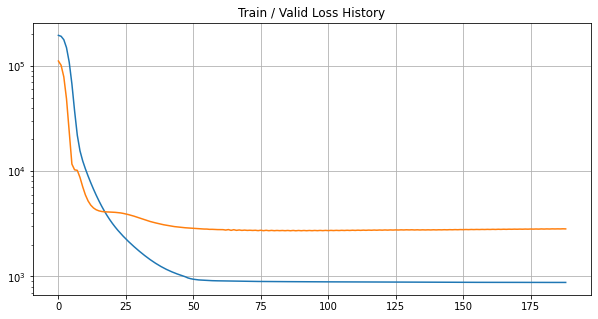

In [ ]:
import matplotlib.pyplot as plt

plot_from = 0
plt.figure(figsize=(10,5))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
range(plot_from, len(train_history)), train_history[plot_from:],
range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [ ]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = test_x.split(batch_size, dim = 0)
    y_ = test_y.split(batch_size, dim = 0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        test_loss += loss
        
        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim = 0)
print(test_loss)

tensor(6168.8184)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


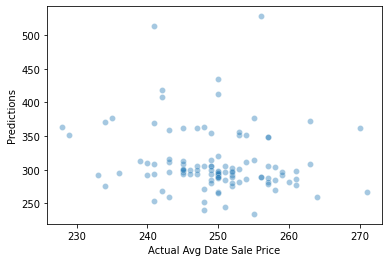

In [ ]:
import seaborn as sns
sns.scatterplot(test_y, y_hat.squeeze(), alpha = .4) 
plt.xlabel('Actual Avg Date Sale Price')
plt.ylabel('Predictions')
plt.show()

### Random Forest Regression

In [ ]:
# Train/Valid/Test로 나누지 않고 그냥 Train/Test로 나눠서 수립해보기
train_x = pd.concat([train_x, valid_x], axis = 0)
train_y = pd.concat([train_y, valid_y], axis = 0)

train_x.reset_index(drop = True, inplace = True)

print(train_x.shape, train_y.shape)

(424, 6) (424,)


In [ ]:
# 문자열인 "Buyer Region" 변수를 One-hot Encoder를 통해 One-Hot Vector로 변환
# One-Hot Encoder 사용 예시 참고: https://psystat.tistory.com/136
# 주의! Train/Test를 나눈 후에 Encoder를 통해 Categorical 변수를 Vector화시킨다!
# LabelEncoder는 Target Value에 적용해야하지, input인 x에 적용하면 안 된다고 함!!! (참고: https://stackoverflow.com/questions/61217713/labelencoder-for-categorical-features/61217936#61217936)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore') # handle_unknown = 'ignore': Train 데이터를 기준으로 OneHot Encoder가 Fit하는데, Valid나 Test Set에서 Train 데이터에서 못 본 데이터가 있을 경우, 해당 Categorical Value는 0, 0, 0, ..., 0 과 같이 다 값이 0인 벡터로 바꿈
train_cat = ohe.fit_transform(train_x[['Buyer Region']])
test_cat = ohe.transform(test_x[['Buyer Region']])

# Buyer Region 변수를 OneHot Encoding 적용한 후 원래 데이터 프레임에 합쳐주기
oh_train_df = pd.DataFrame(train_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
train_x = pd.concat([train_x.drop(columns = ['Buyer Region']), oh_train_df], axis = 1)

oh_test_df = pd.DataFrame(test_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
test_x = pd.concat([test_x.drop(columns = ['Buyer Region']), oh_test_df], axis = 1)

print((train_x.shape, train_y.shape))
print((test_x.shape, test_y.shape))


((424, 47), (424,))
((107, 47), (107,))


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_reg = RandomForestRegressor()
forest_reg.fit(train_x, train_y)
y_predicted = forest_reg.predict(test_x)

forest_reg_mse = mean_squared_error(test_y, y_predicted)
forest_reg_rmse = np.sqrt(forest_reg_mse)

print('Random Forest Regressor MSE: ',forest_reg_mse)
print('Random Forest Regressor RMSE: ',forest_reg_rmse)

Random Forest Regressor MSE:  77.77437102803736
Random Forest Regressor RMSE:  8.818977890211391


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


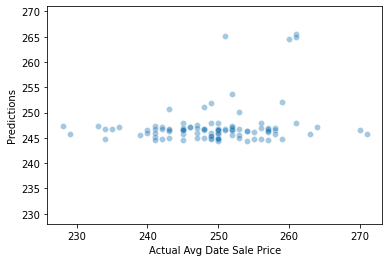

In [ ]:
import seaborn as sns
sns.scatterplot(test_y, y_predicted, alpha = .4)
plt.xlabel('Actual Avg Date Sale Price')
plt.ylabel('Predictions')
plt.ylim([test_y.min(),test_y.max()])
plt.show()

### (Other) Regressor

In [ ]:
# Train/Valid/Test로 나누지 않고 그냥 Train/Test로 나눠서 수립해보기
train_x = pd.concat([train_x, valid_x], axis = 0)
train_y = pd.concat([train_y, valid_y], axis = 0)

train_x.reset_index(drop = True, inplace = True)

print(train_x.shape, train_y.shape)

(424, 6) (424,)


In [ ]:
# 문자열인 "Buyer Region" 변수를 One-hot Encoder를 통해 One-Hot Vector로 변환
# One-Hot Encoder 사용 예시 참고: https://psystat.tistory.com/136
# 주의! Train/Test를 나눈 후에 Encoder를 통해 Categorical 변수를 Vector화시킨다!
# LabelEncoder는 Target Value에 적용해야하지, input인 x에 적용하면 안 된다고 함!!! (참고: https://stackoverflow.com/questions/61217713/labelencoder-for-categorical-features/61217936#61217936)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore') # handle_unknown = 'ignore': Train 데이터를 기준으로 OneHot Encoder가 Fit하는데, Valid나 Test Set에서 Train 데이터에서 못 본 데이터가 있을 경우, 해당 Categorical Value는 0, 0, 0, ..., 0 과 같이 다 값이 0인 벡터로 바꿈
train_cat = ohe.fit_transform(train_x[['Buyer Region']])
test_cat = ohe.transform(test_x[['Buyer Region']])

# Buyer Region 변수를 OneHot Encoding 적용한 후 원래 데이터 프레임에 합쳐주기
oh_train_df = pd.DataFrame(train_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
train_x = pd.concat([train_x.drop(columns = ['Buyer Region']), oh_train_df], axis = 1)

oh_test_df = pd.DataFrame(test_cat, columns = ['Buyer Region_' + col for col in ohe.categories_[0]])
test_x = pd.concat([test_x.drop(columns = ['Buyer Region']), oh_test_df], axis = 1)

print((train_x.shape, train_y.shape))
print((test_x.shape, test_y.shape))

((424, 47), (424,))
((107, 47), (107,))


In [ ]:
train_x.describe()

,Order Date,Sale Price,Shoe Size,Days After Release,Previous Order Date,Buyer Region_Alabama,Buyer Region_Alaska,Buyer Region_Arizona,Buyer Region_California,Buyer Region_Colorado,Buyer Region_Connecticut,Buyer Region_Delaware,Buyer Region_District of Columbia,Buyer Region_Florida,Buyer Region_Georgia,Buyer Region_Hawaii,Buyer Region_Idaho,Buyer Region_Illinois,Buyer Region_Indiana,Buyer Region_Iowa,Buyer Region_Kansas,Buyer Region_Kentucky,Buyer Region_Louisiana,Buyer Region_Maine,Buyer Region_Maryland,Buyer Region_Massachusetts,Buyer Region_Michigan,Buyer Region_Minnesota,Buyer Region_Nebraska,Buyer Region_Nevada,Buyer Region_New Hampshire,Buyer Region_New Jersey,Buyer Region_New Mexico,Buyer Region_New York,Buyer Region_North Carolina,Buyer Region_Ohio,Buyer Region_Oklahoma,Buyer Region_Oregon,Buyer Region_Pennsylvania,Buyer Region_South Carolina,Buyer Region_South Dakota,Buyer Region_Tennessee,Buyer Region_Texas,Buyer Region_Utah,Buyer Region_Virginia,Buyer Region_Washington,Buyer Region_Wisconsin
count,424.00000,424.000000,424.000000,424.00000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.00000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,736784.50000,412.299528,275.176887,336.50000,736784.752358,0.004717,0.002358,0.028302,0.172170,0.016509,0.016509,0.009434,0.002358,0.068396,0.018868,0.004717,0.004717,0.023585,0.016509,0.004717,0.007075,0.002358,0.004717,0.004717,0.007075,0.028302,0.037736,0.004717,0.004717,0.011792,0.004717,0.044811,0.002358,0.12500,0.014151,0.018868,0.002358,0.087264,0.021226,0.004717,0.002358,0.007075,0.080189,0.002358,0.028302,0.035377,0.011792
std,122.54251,82.018838,19.985913,122.54251,123.088054,0.068599,0.048564,0.166030,0.377974,0.127575,0.127575,0.096784,0.048564,0.252723,0.136219,0.068599,0.068599,0.151931,0.127575,0.068599,0.083917,0.048564,0.068599,0.068599,0.083917,0.166030,0.190782,0.068599,0.068599,0.108078,0.068599,0.207134,0.048564,0.33111,0.118253,0.136219,0.048564,0.282555,0.144309,0.068599,0.048564,0.083917,0.271906,0.048564,0.166030,0.184950,0.108078
min,736573.00000,207.000000,220.000000,125.00000,736573.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,736678.75000,370.000000,265.000000,230.75000,736678.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,736784.50000,415.000000,275.000000,336.50000,736784.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,736890.25000,452.750000,290.000000,442.25000,736890.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,